In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [34]:
train_df = pd.read_csv('/kaggle/input/neural-net-nexus/train.csv') # Adjust path if necessary
test_df = pd.read_csv('/kaggle/input/neural-net-nexus/test.csv')   # Adjust path if necessary

In [35]:
train_df.head() # Display the first few rows of the training data

,Age,HB (gm/dl),ESR(mm),WBC(TC) (/cumm),Neutrophils (%),lymphocytes (%),Monocytes (%),Eosinophils (%),Cir Eosinophils (/cumm),RBC (m/ul),...,Platelete(PC)(/cumm),MPV (fl),PCT (%),Class Identification,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,14.0,11.4,28.0,4200.0,57,36,5.0,2.0,84.0,4.64,...,167000.0,10.3,0.07,Negative,NaN,NaN,NaN,NaN,NaN,NaN
1,26.0,12.2,43.0,4700.0,77,19,3.0,1.0,47.0,4.24,...,277000.0,8.5,0.24,Positive,NaN,NaN,NaN,NaN,NaN,NaN
2,42.0,14.9,103.0,19800.0,82,15,2.0,1.0,198.0,5.31,...,215000.0,9.1,0.20,Negative,NaN,NaN,NaN,NaN,NaN,NaN
3,35.0,13.9,12.0,9700.0,88,10,1.0,1.0,97.0,5.49,...,282000.0,8.7,0.25,Negative,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,10.0,28.0,10600.0,46,42,2.0,10.0,1060.0,3.99,...,337000.0,7.6,0.26,Negative,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
test_df.head() # Display the first few rows of the test data

,Age,HB (gm/dl),ESR(mm),WBC(TC) (/cumm),Neutrophils (%),lymphocytes (%),Monocytes (%),Eosinophils (%),Cir Eosinophils (/cumm),RBC (m/ul),HTC/PCV (%),MCV (fl),MCH (pg),MCHC (g/dl),RDW (%),PDW (fl),Platelete(PC)(/cumm),MPV (fl),PCT (%)
0,60.0,11.4,34.0,6900,55,38,4,3,207,4.00,38.4,96.0,28.5,29.7,14.0,11.3,352000,7.2,0.26
1,55.0,12.5,59.0,13100,53,41,2,4,524,4.47,40.0,89.5,28.0,31.3,13.7,12.3,572000,7.9,0.45
2,14.0,11.4,41.0,10900,45,46,1,8,872,4.25,37.0,87.1,26.8,30.8,13.2,NaN,481000,8.1,0.39
3,28.0,9.7,68.0,8400,59,36,4,1,84,3.88,31.6,81.4,25.0,30.7,13.6,11.9,228000,8.2,0.19
4,60.0,10.6,50.0,5800,62,33,4,1,58,4.16,35.7,85.8,25.5,29.7,13.7,13.9,253000,8.5,0.22


In [37]:
train_df.info() # Get information about data types and missing values in train data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      526 non-null    float64
 1   HB (gm/dl)               529 non-null    float64
 2   ESR(mm)                  529 non-null    float64
 3   WBC(TC) (/cumm)          528 non-null    float64
 4   Neutrophils (%)          529 non-null    int64  
 5   lymphocytes (%)          529 non-null    int64  
 6   Monocytes (%)            527 non-null    float64
 7   Eosinophils (%)          527 non-null    float64
 8   Cir Eosinophils (/cumm)  526 non-null    float64
 9   RBC (m/ul)               527 non-null    float64
 10  HTC/PCV (%)              529 non-null    float64
 11  MCV (fl)                 526 non-null    float64
 12  MCH (pg)                 528 non-null    float64
 13  MCHC (g/dl)              529 non-null    float64
 14  RDW  (%)                 5

In [38]:
test_df.info() # Get information about data types and missing values in test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      100 non-null    float64
 1   HB (gm/dl)               100 non-null    float64
 2   ESR(mm)                  98 non-null     float64
 3   WBC(TC) (/cumm)          100 non-null    int64  
 4   Neutrophils (%)          100 non-null    int64  
 5   lymphocytes (%)          100 non-null    int64  
 6   Monocytes (%)            100 non-null    int64  
 7   Eosinophils (%)          100 non-null    int64  
 8   Cir Eosinophils (/cumm)  100 non-null    int64  
 9   RBC (m/ul)               100 non-null    float64
 10  HTC/PCV (%)              100 non-null    float64
 11  MCV (fl)                 100 non-null    float64
 12  MCH (pg)                 100 non-null    float64
 13  MCHC (g/dl)              100 non-null    float64
 14  RDW  (%)                 10

In [39]:
train_df.describe() # Get statistical summary of numerical features in train data

,Age,HB (gm/dl),ESR(mm),WBC(TC) (/cumm),Neutrophils (%),lymphocytes (%),Monocytes (%),Eosinophils (%),Cir Eosinophils (/cumm),RBC (m/ul),...,PDW (fl),Platelete(PC)(/cumm),MPV (fl),PCT (%),Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
count,526.000000,529.000000,529.000000,528.000000,529.000000,529.000000,527.000000,527.000000,526.000000,527.000000,...,529.000000,527.000000,528.000000,529.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,33.581559,12.190302,34.732892,10406.557576,60.100189,32.103970,3.857685,4.370019,392.422053,5.590873,...,16.235892,259977.546490,8.988087,0.779527,NaN,NaN,NaN,NaN,NaN,NaN
std,18.125759,1.933937,26.449178,10859.193047,13.842710,12.559199,3.368476,3.666425,682.495748,17.314824,...,9.026046,126046.800563,1.614692,11.156724,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,4.200000,0.000000,14.400000,17.000000,5.000000,1.000000,0.000000,0.000000,2.730000,...,0.000000,5800.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,19.250000,10.900000,14.000000,6500.000000,52.000000,23.000000,2.000000,2.000000,107.250000,4.300000,...,11.500000,169883.000000,7.815000,0.170000,NaN,NaN,NaN,NaN,NaN,NaN
50%,32.000000,12.200000,27.000000,8850.000000,60.000000,31.000000,3.000000,3.000000,218.500000,4.700000,...,13.000000,259000.000000,8.795000,0.230000,NaN,NaN,NaN,NaN,NaN,NaN
75%,45.750000,13.700000,50.000000,11900.000000,69.000000,39.000000,5.000000,5.000000,484.250000,5.215000,...,15.900000,333732.500000,10.100000,0.320000,NaN,NaN,NaN,NaN,NaN,NaN
max,85.000000,16.700000,127.000000,129000.000000,91.000000,74.000000,58.000000,28.000000,13100.000000,401.000000,...,50.100000,737000.000000,14.400000,256.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
test_df.describe() # Get statistical summary of numerical features in test data

,Age,HB (gm/dl),ESR(mm),WBC(TC) (/cumm),Neutrophils (%),lymphocytes (%),Monocytes (%),Eosinophils (%),Cir Eosinophils (/cumm),RBC (m/ul),HTC/PCV (%),MCV (fl),MCH (pg),MCHC (g/dl),RDW (%),PDW (fl),Platelete(PC)(/cumm),MPV (fl),PCT (%)
count,100.000000,100.000000,98.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,100.000000,100.000000
mean,31.338000,11.767000,36.795918,10392.000000,59.320000,32.740000,3.56000,4.020000,367.350000,4.61030,37.980000,81.530000,26.317000,30.973000,14.704000,13.359596,314950.000000,8.619000,0.266300
std,18.884074,1.700508,27.036043,10240.321176,12.319714,10.918079,2.28884,2.601398,338.931755,0.63881,4.991994,11.204477,6.735359,1.501975,2.217147,4.719087,137526.517186,1.440868,0.105913
min,1.800000,8.000000,2.000000,2600.000000,26.000000,9.000000,1.00000,0.000000,0.000000,3.10000,27.800000,27.200000,15.900000,28.100000,10.100000,10.100000,22000.000000,6.600000,0.010000
25%,18.000000,10.600000,13.250000,6875.000000,50.000000,25.750000,2.00000,2.000000,105.750000,4.18000,35.200000,79.375000,24.575000,30.000000,13.600000,11.400000,227000.000000,7.575000,0.200000
50%,25.500000,11.550000,34.000000,9200.000000,59.500000,33.000000,3.00000,4.000000,223.000000,4.46500,37.500000,84.650000,26.250000,30.600000,14.100000,12.400000,313500.000000,8.150000,0.270000
75%,40.500000,12.900000,49.000000,11825.000000,67.000000,41.000000,5.00000,5.000000,519.500000,5.04000,40.825000,87.500000,28.000000,31.300000,15.175000,13.650000,388250.000000,9.325000,0.350000
max,90.000000,15.400000,120.000000,106000.000000,86.000000,65.000000,11.00000,14.000000,1568.000000,6.29000,49.300000,96.000000,85.200000,35.000000,25.200000,49.200000,648000.000000,12.700000,0.470000


In [41]:
train_df['Class Identification'].value_counts() # Check the distribution of the target variable

Class Identification
Negative    362
Positive    138
Normal       16
Abnormal     13
Name: count, dtype: int64

In [42]:
# Identify unnamed columns
unnamed_cols = [col for col in train_df.columns if 'Unnamed' in col]
print("Unnamed columns found:", unnamed_cols)

# Drop unnamed columns from both train and test datasets
train_df = train_df.drop(columns=unnamed_cols)
test_df = test_df.drop(columns=unnamed_cols, errors='ignore') # Use errors='ignore' in test_df in case these cols are not present

train_df.head() # Verify that unnamed columns are dropped
test_df.head()

Unnamed columns found: ['Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25']


,Age,HB (gm/dl),ESR(mm),WBC(TC) (/cumm),Neutrophils (%),lymphocytes (%),Monocytes (%),Eosinophils (%),Cir Eosinophils (/cumm),RBC (m/ul),HTC/PCV (%),MCV (fl),MCH (pg),MCHC (g/dl),RDW (%),PDW (fl),Platelete(PC)(/cumm),MPV (fl),PCT (%)
0,60.0,11.4,34.0,6900,55,38,4,3,207,4.00,38.4,96.0,28.5,29.7,14.0,11.3,352000,7.2,0.26
1,55.0,12.5,59.0,13100,53,41,2,4,524,4.47,40.0,89.5,28.0,31.3,13.7,12.3,572000,7.9,0.45
2,14.0,11.4,41.0,10900,45,46,1,8,872,4.25,37.0,87.1,26.8,30.8,13.2,NaN,481000,8.1,0.39
3,28.0,9.7,68.0,8400,59,36,4,1,84,3.88,31.6,81.4,25.0,30.7,13.6,11.9,228000,8.2,0.19
4,60.0,10.6,50.0,5800,62,33,4,1,58,4.16,35.7,85.8,25.5,29.7,13.7,13.9,253000,8.5,0.22


In [43]:
train_df.isnull().sum() # Count missing values in each column of train data

Age                        3
HB (gm/dl)                 0
ESR(mm)                    0
WBC(TC) (/cumm)            1
Neutrophils (%)            0
lymphocytes (%)            0
Monocytes (%)              2
Eosinophils (%)            2
Cir Eosinophils (/cumm)    3
RBC (m/ul)                 2
HTC/PCV (%)                0
MCV (fl)                   3
MCH (pg)                   1
MCHC (g/dl)                0
RDW  (%)                   1
PDW (fl)                   0
Platelete(PC)(/cumm)       2
MPV (fl)                   1
PCT (%)                    0
Class Identification       0
dtype: int64

In [44]:
# Identify numerical columns for imputation (exclude target column and any categorical if present)
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
#numerical_cols.remove('Class Identification') # Remove target column from numerical columns to impute

imputer = SimpleImputer(strategy='median') # Use median strategy
train_df[numerical_cols] = imputer.fit_transform(train_df[numerical_cols]) # Fit on train and transform train
test_df[numerical_cols] = imputer.transform(test_df[numerical_cols])       # Transform test data using fitted imputer

train_df.isnull().sum().sum() # Verify if there are any missing values left in train
test_df.isnull().sum().sum()  # Verify for test data

0

In [45]:
train_df['Class Identification'] = train_df['Class Identification'].map({'Negative': 0, 'Positive': 1})
train_df['Class Identification'].value_counts() # Check the conversion

Class Identification
0.0    362
1.0    138
Name: count, dtype: int64

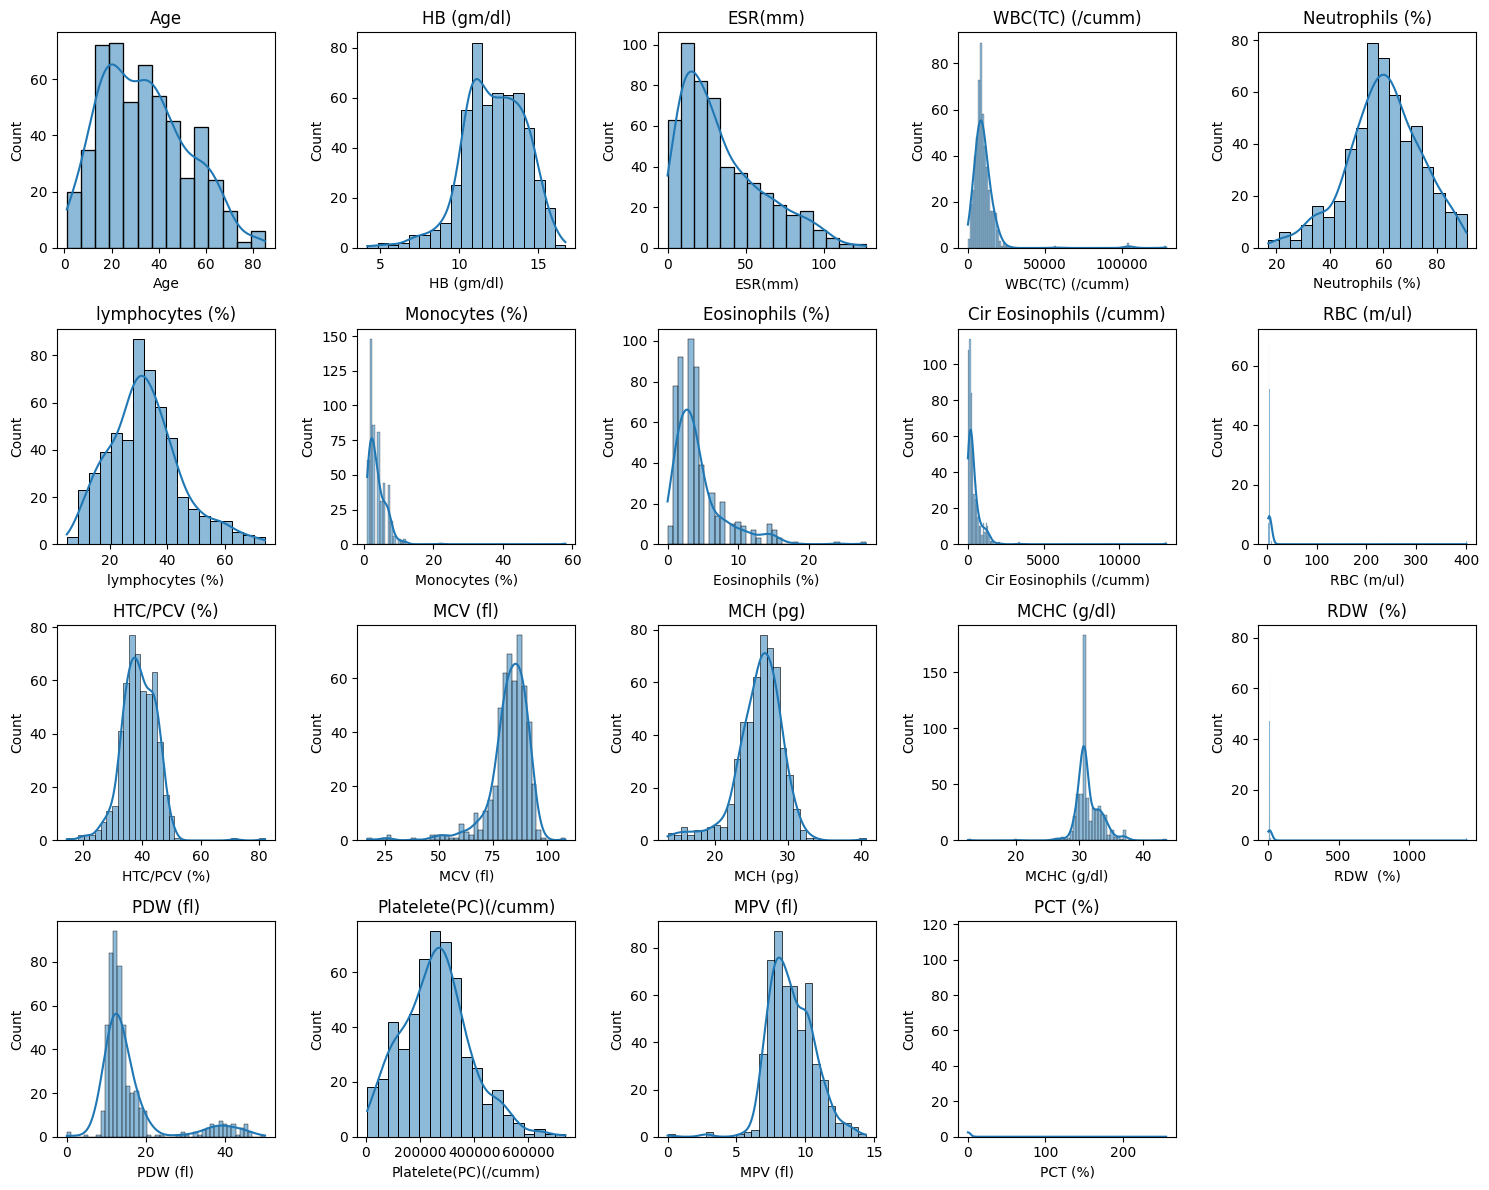

In [46]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 5, i+1) # Adjust subplot layout as needed
    sns.histplot(train_df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

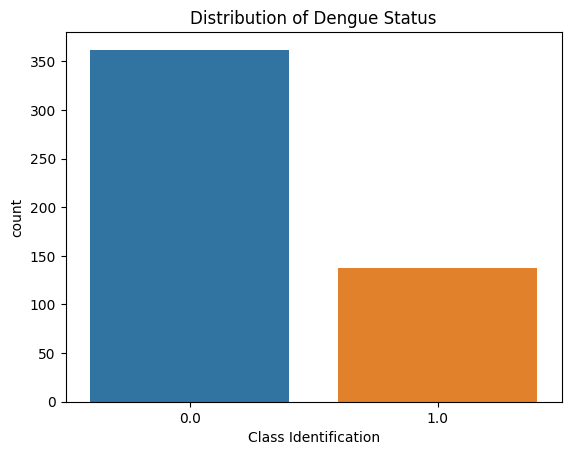

In [47]:
sns.countplot(x='Class Identification', data=train_df)
plt.title('Distribution of Dengue Status')
plt.show()

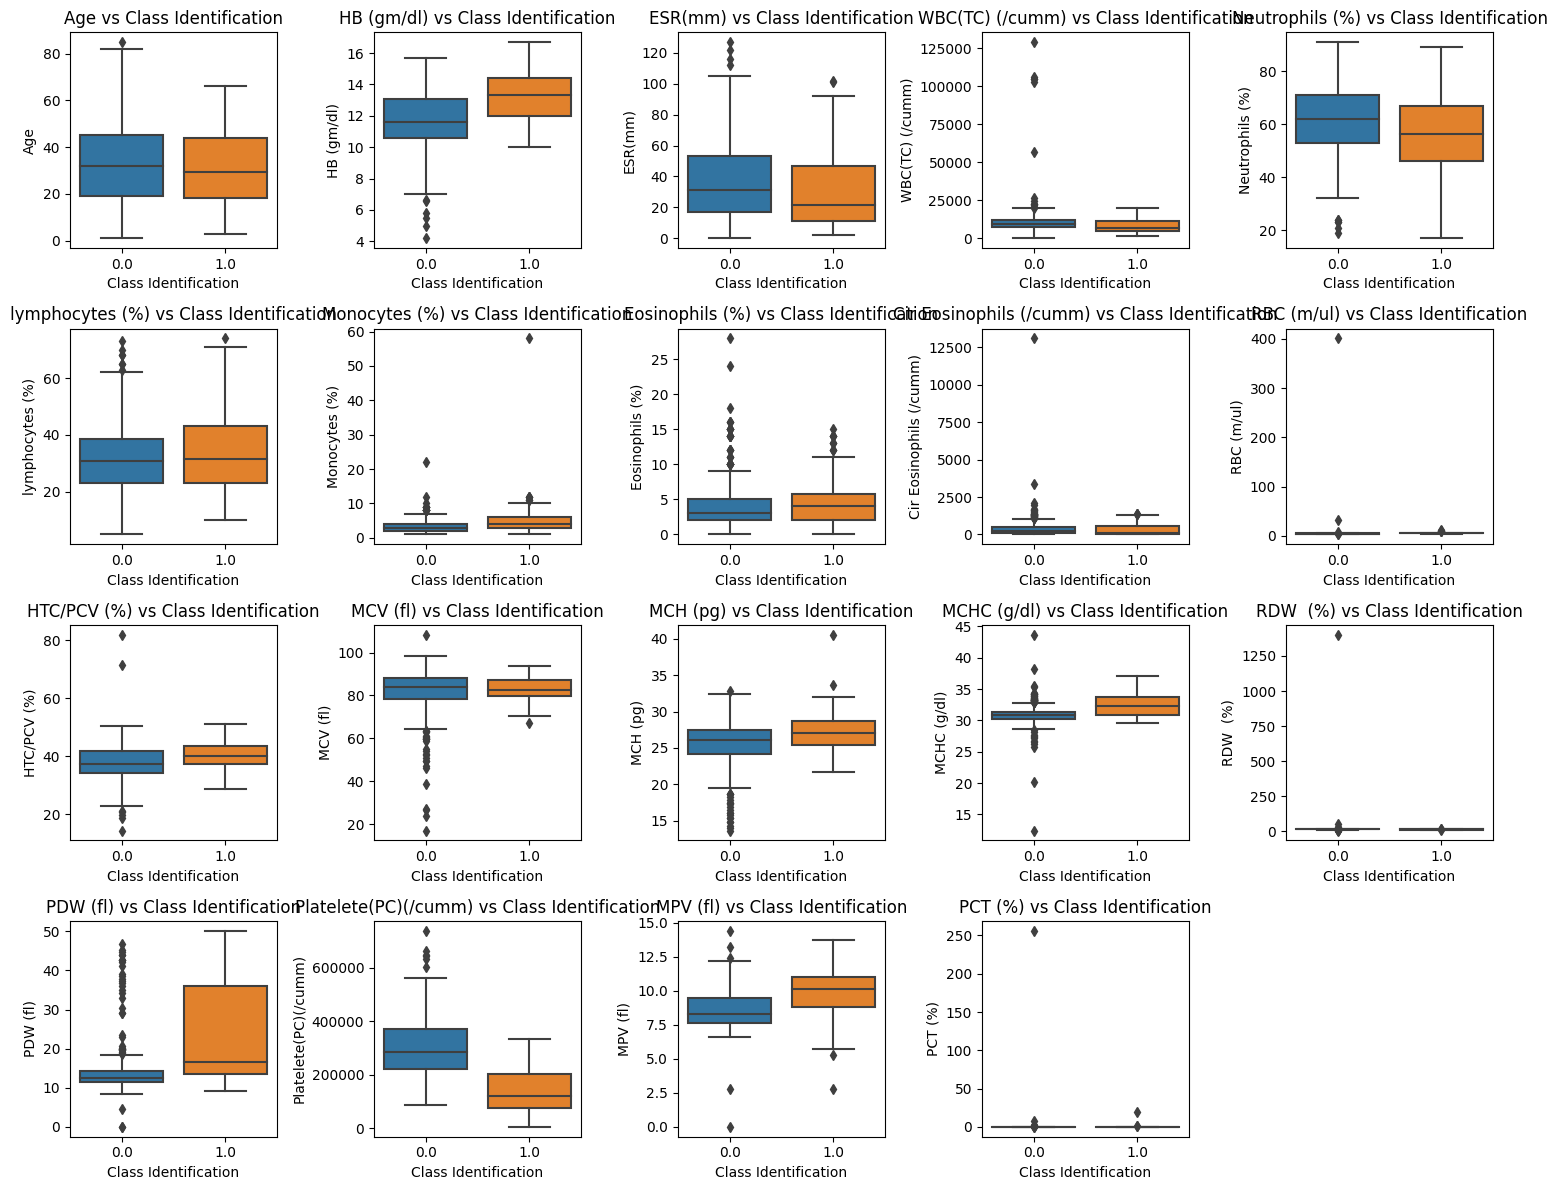

In [48]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 5, i+1) # Adjust subplot layout as needed
    sns.boxplot(x='Class Identification', y=col, data=train_df)
    plt.title(f'{col} vs Class Identification')
plt.tight_layout()
plt.show()

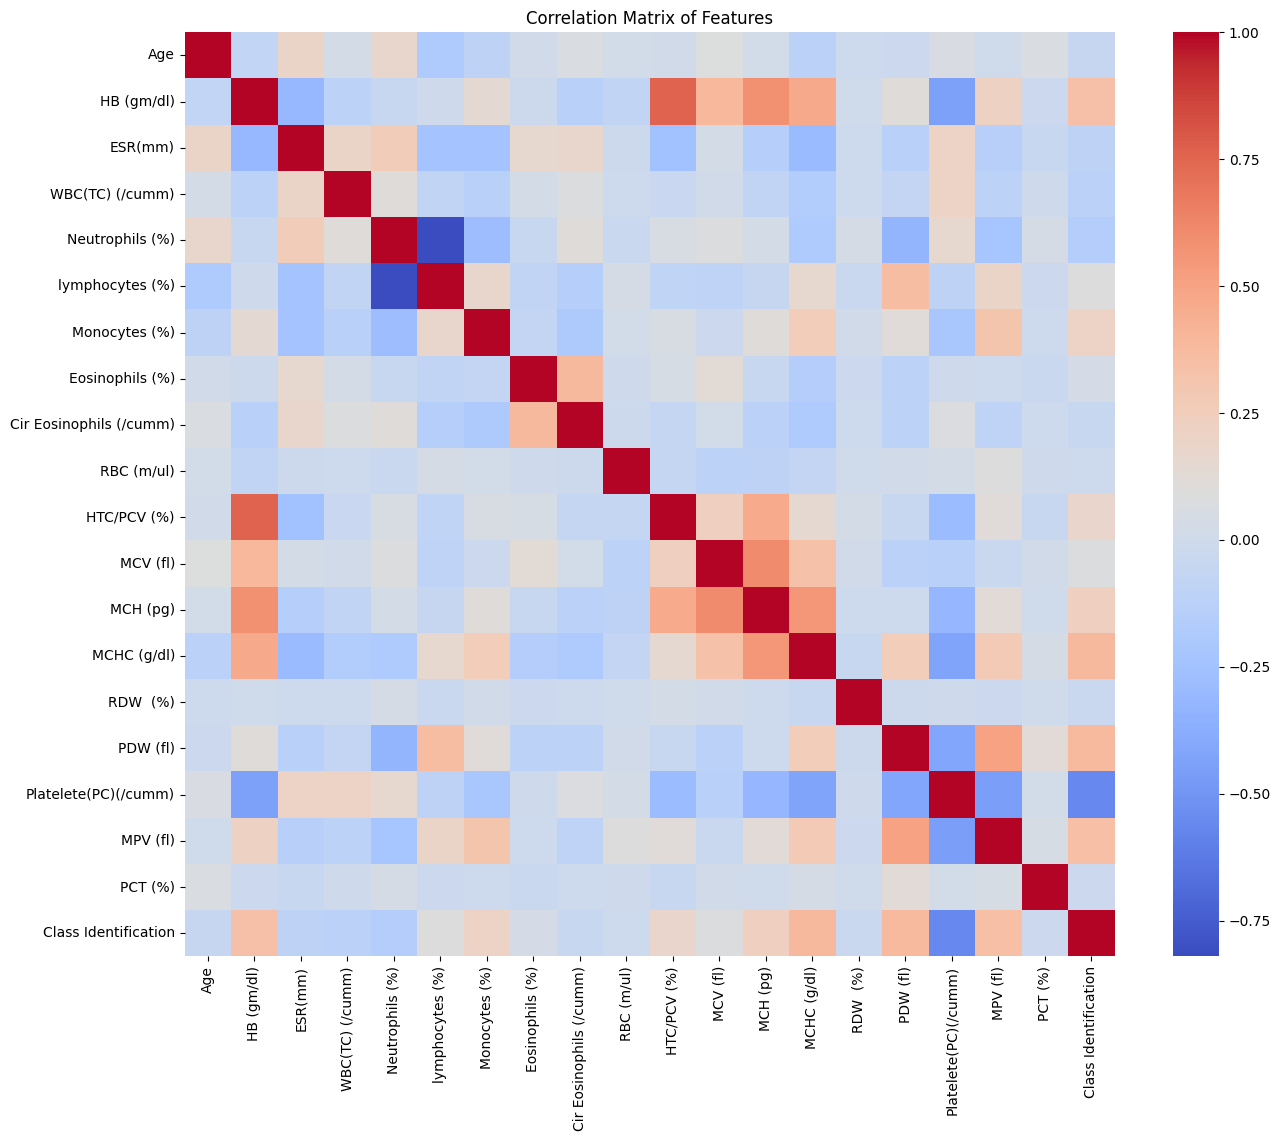

In [49]:
correlation_matrix = train_df[numerical_cols + ['Class Identification']].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm') # Annot=True to show values, but can be cluttered
plt.title('Correlation Matrix of Features')
plt.show()

# **Feature engineering**

Neutrophil_Lymphocyte_Ratio

In [51]:
train_df['Neutrophil_Lymphocyte_Ratio'] = train_df['Neutrophils (%)'] / (train_df['lymphocytes (%)'] + 1e-6) # Adding a small value to avoid division by zero
test_df['Neutrophil_Lymphocyte_Ratio'] = test_df['Neutrophils (%)'] / (test_df['lymphocytes (%)'] + 1e-6)

# Add more feature engineering steps based on EDA and domain knowledge here.
# For now, let's proceed with this single engineered feature.

engineered_numerical_cols = numerical_cols + ['Neutrophil_Lymphocyte_Ratio'] # Update numerical columns list

In [52]:
scaler = StandardScaler()
train_df[engineered_numerical_cols] = scaler.fit_transform(train_df[engineered_numerical_cols]) # Fit and transform train
test_df[engineered_numerical_cols] = scaler.transform(test_df[engineered_numerical_cols])       # Transform test

In [54]:
print("Number of NaN values in 'Class Identification' column (y):", train_df['Class Identification'].isnull().sum())

Number of NaN values in 'Class Identification' column (y): 29


In [55]:
print("Unique values in original 'Class Identification' column:")
print(train_df['Class Identification'].unique()) # Before mapping, if you still have the original

Unique values in original 'Class Identification' column:
[ 0.  1. nan]


In [56]:
print("Unique values in original 'Class Identification' column:")
print(train_df['Class Identification'].unique()) # Before mapping, if you still have the original

Unique values in original 'Class Identification' column:
[ 0.  1. nan]


In [57]:
print("Original shape of train_df:", train_df.shape)

# Remove rows where 'Class Identification' is NaN
train_df = train_df.dropna(subset=['Class Identification'])

print("Shape of train_df after removing rows with NaN in 'Class Identification':", train_df.shape)
print("Number of NaN values in 'Class Identification' column after removal:", train_df['Class Identification'].isnull().sum()) # Verify again

Original shape of train_df: (529, 21)
Shape of train_df after removing rows with NaN in 'Class Identification': (500, 21)
Number of NaN values in 'Class Identification' column after removal: 0


In [59]:
# Prepare Data for Modeling:

# Make sure to redefine X and y AFTER removing NaN rows
X = train_df[engineered_numerical_cols] # Features
y = train_df['Class Identification']    # Target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) # Stratify to maintain class balance

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (400, 20)
Shape of X_val: (100, 20)
Shape of y_train: (400,)
Shape of y_val: (100,)


In [61]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), # eval_metric for AUC
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
     'Logistic Regression': { # Example, you can tune C or penalty
        'C': [0.1, 1, 10]
    }
}

In [62]:
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified K-Fold

for name, model in models.items():
    print(f"Training and tuning {name}...")
    grid_search = GridSearchCV(model, param_grids.get(name, {}), scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1) # roc_auc for AUC-ROC, n_jobs=-1 for parallel processing
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"{name} Best Parameters: {grid_search.best_params_}")
    print(f"{name} Best AUC ROC (Validation): {grid_search.best_score_:.4f}\n")

Training and tuning Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression Best Parameters: {'C': 10}
Logistic Regression Best AUC ROC (Validation): 0.8666

Training and tuning Random Forest...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best AUC ROC (Validation): 0.9528

Training and tuning Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Gradient Boosting Best AUC ROC (Validation): 0.9475

Training and tuning XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost Best AUC ROC (Validation): 0.9473

Training and tuning LightGBM...
Fitting 5 folds for each of 

In [ ]:
print("Validation Performance of Best Models:")
for name, model in best_models.items():
    y_pred_proba_val = model.predict_proba(X_val)[:, 1] # Probabilities for positive class
    auc_roc_val = roc_auc_score(y_val, y_pred_proba_val)
    print(f"{name} AUC ROC (Validation): {auc_roc_val:.4f}")

In [ ]:
best_model_name = 'Random Forest' # Or whichever model performed best
best_model = best_models[best_model_name]

X_test = test_df[engineered_numerical_cols] # Features for test data
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1] # Predicted probabilities for test set



In [ ]:
submission_df = pd.DataFrame({'ID': range(1, len(test_df) + 1), 'Prediction': y_pred_proba_test})
submission_df.to_csv('submission.csv', index=False)

In [63]:
best_model_name = 'Random Forest' #model performed best (ensure this is correctly set after model evaluation)
best_model = best_models[best_model_name]

X_test = test_df[engineered_numerical_cols] # Features for test data
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1] # Predicted probabilities for test set

# Apply threshold of 0.5 to get binary predictions (0 or 1)
threshold = 0.5
y_pred_binary_test = (y_pred_proba_test >= threshold).astype(int)

# Now, y_pred_binary_test contains predictions as 0 or 1

# Update the submission DataFrame to use binary predictions instead of probabilities
submission_df = pd.DataFrame({'ID': range(1, len(test_df) + 1), 'Prediction': y_pred_binary_test})
submission_df.to_csv('Model_RF.csv', index=False)

print("First 10 probability predictions:")
print(y_pred_proba_test[:10]) # Print first 10 probabilities

print("\nFirst 10 binary predictions (threshold=0.5):")
print(y_pred_binary_test[:10]) # Print first 10 binary predictions

print("\nSubmission DataFrame with binary predictions:")
print(submission_df.head()) # Print the head of the submission DataFrame to verify

First 10 probability predictions:
[0.005 0.05  0.08  0.015 0.055 0.    0.07  0.03  0.08  0.03 ]

First 10 binary predictions (threshold=0.5):
[0 0 0 0 0 0 0 0 0 0]

Submission DataFrame with binary predictions:
   ID  Prediction
0   1           0
1   2           0
2   3           0
3   4           0
4   5           0


In [64]:
import joblib

best_model_name = 'Random Forest'  
best_model = best_models[best_model_name] # Assuming your best models are in best_models dictionary

# Save the best model in .joblib format, named as your team name
model_filename = 'Grok.joblib'
joblib.dump(best_model, model_filename)

print(f"Best model '{best_model_name}' saved as '{model_filename}' in .joblib format.")

Best model 'Random Forest' saved as 'Grok.joblib' in .joblib format.
